In [0]:
import pandas as pd
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 1. Job postings analysis

## 1.1 Import job postings dataset 
- Source: https://data.world/jobspikr/10000-data-scientist-job-postings-from-the-usa
- This dataset contains 10000 job postings of data scientist from the USA

In [0]:
df = pd.read_csv('DS_job_postings.csv',low_memory=False)

In [0]:
df.head(2)

,crawl_timestamp,url,job_title,category,company_name,city,state,country,inferred_city,inferred_state,...,job_description,job_type,salary_offered,job_board,geo,cursor,contact_email,contact_phone_number,uniq_id,html_job_description
0,2019-02-06 05:26:22 +0000,https://www.indeed.com/viewjob?jk=fd83355c2b23...,Enterprise Data Scientist I,Accounting/Finance,Farmers Insurance Group,Woodland Hills,CA,Usa,Woodland hills,California,...,Read what people are saying about working here...,Undefined,NaN,indeed,usa,1549432819114777,NaN,NaN,3b6c6acfcba6135a31c83bd7ea493b18,NaN
1,2019-02-06 05:33:41 +0000,https://www.dice.com/jobs/detail/Data-Scientis...,Data Scientist,NaN,Luxoft USA Inc,Middletown,NJ,Usa,Middletown,New jersey,...,We have an immediate opening for a Sharp Data ...,Undefined,NaN,dice,usa,1549432819122106,NaN,NaN,741727428839ae7ada852eebef29b0fe,NaN


In [0]:
# print out popular data scientist job titles
job_count = df['job_title'].value_counts()
job_count[job_count>50]

Data Scientist              2889
Senior Data Scientist        644
Sr. Data Scientist           203
Lead Data Scientist          179
Principal Data Scientist     148
Data Scientist II            107
Associate Data Scientist      82
Sr Data Scientist             81
Junior Data Scientist         53
Name: job_title, dtype: int64

## 1.2 Data cleaning 

**Job description** will be used to analyze because it contains the most useful information such as requirments and expected works to do. 

In [0]:
df['job_description'].isnull().sum() # No NaN in the job description

0

In [0]:
def cleaner(txt):
    '''
    This function helps to clean the text data by removing special characters, numbers and uninformative words 
    '''
    # remove \n
    txt = txt.replace('\n',' ')
    # remove special characters
    txt = re.sub(r'[^A-Za-z0-9]+', ' ', txt)
    # remove single digits only 
    txt = re.sub('^\d+\s|\s\d+\s|\s\d+$', ' ', txt)
    # remove stop word
    txt = re.sub(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*', '', txt)
    return ''.join(txt)

In [0]:
job_clean = df['job_description'].apply(cleaner) # apply the function above 

## 1.3 Exploratory analysis of data science keywords

The following two dictionaries `skills_hard` and `skills_soft` were constructed from mupliple sources to include a comprehensive list of hard skills related to programming languages, technical skills, and business analysis, and soft skills relevant to the profession of data science, such as management and problem solving.
- The **keys** layer contains skill categories that will be used to compare to each other and make final plots 
- The **values** layer represents a list of keywords corresponding to their category 

Keyword source: including but not limited to https://www.rezrunner.com/blog/data-scientist-resume-keywords-skills/ https://www.datasciencecentral.com/forum/topics/most-popular-data-science-keywords-on-dsc 

In [0]:
# hard skills 
skills_hard = {
        'Excel': ('Excel'),
        'Python': ('Python'),
        'R': (' R '),
        'Java': ('Java|JVM'),
        'Scala': ('Scala'),
        'C/C++': (' C '), 
        'MATLAB': ('MATLAB'),
        'SAS': ('SAS'),
        'SQL/databases': ('SQL|database'),
        'Oracle':('Oracle'),
        'SPSS': ('SPSS'),
        'Machine Learning': ('Machine Learning| ML '),
        'Data Mining/Analytics': ('Data Mining| DM |Analytics'),
        'NLP': ('Natural Language Processing|NLP'),
        'Visualisation': ('Visualisation|Visualization'),
        'Big Data': ('Big Data|Spark|kafka|Hive|Hadoop|MapReduce|Hbase|Coudera|Hortonworks'),
        'AWS/Google Cloud': ('AWS|Google Cloud|GCP'),
        'Probability': ('probability'),
        'Support Vector Machines': ('SVM|Support vector machine'),
        'Neural Networks': ('Neural Networks|ANN|MLP|CNN|Tensorflow|Keras|Theano|deep learning|MNIST'),
        'JSON': ('Json'),
        'Azure': ('Azure'),
        'Mathematics': ('Mathematics|Mathematical'),
        'Algebra': ('Algebra'),
        'Statistics' :  ('Statistics|Statistical'),
        'Operations research': ('Operations research'),
        'DevOps': ('DevOps|TDD|test driven'),
        'Git':('Github|Git|version control')
}
# soft skills
skills_soft = {
        'Presentation' : ('communication|presentation'),
        'agile' : ('agile'),
        'SDLC' : ('SDLC|software development|lifecycle'),
        'Decision making' : ('decision making|decision analysis'),
        'problem solving': ('problem solving|critical thinking'),
        'Team building': ('team building|teamwork|team work|collaborate'),
        'Project management': ('project management|project manager|management'),
        'Leadership': ('leadership|leader'),
        'Consulting': ('consulting|consultant|consultation'),
        'Passion': ('passion'),
        'Research':('research')
}

In [0]:
def skills_table(keywords,df):
    '''
    This function makes one hot encoding for each keywords category:
    take each categoty as column. If any of its keywords are mentioned for each job posting,
    return 1, else return 0
    '''
    result=pd.DataFrame()
    for k,v in keywords.items():
        result[k] = df.str.contains(v,regex=True,case=False)
        result.loc[result[k]==True,k] =1
        result.loc[result[k]==False,k]=0
    return result

In [0]:
# apply the above function and make both hard skill table and soft skill table
table_hard = skills_table(skills_hard,job_clean)
table_soft = skills_table(skills_soft,job_clean)

In [0]:
table_hard.sum().sort_values(ascending=False) # sort the frequency of hard skill categories in order

Python                     7958
Statistics                 7807
Machine Learning           7286
Data Mining/Analytics      7022
SQL/databases              6546
R                          6256
Neural Networks            5487
Big Data                   5237
Mathematics                4529
Excel                      3955
Visualisation              3761
Java                       2469
Scala                      2377
AWS/Google Cloud           2356
Git                        2311
SAS                        2217
NLP                        1897
C/C++                      1629
Operations research        1334
MATLAB                      938
Azure                       932
Oracle                      688
SPSS                        525
Support Vector Machines     483
Probability                 416
DevOps                      245
Algebra                     211
JSON                        120
dtype: int64

In [0]:
table_soft.sum().sort_values(ascending=False) # sort the frequency of soft skill categories in order

Presentation          5518
Research              5013
Project management    4401
Leadership            3866
Team building         3007
Passion               2423
problem solving       2312
Consulting            1518
SDLC                  1363
Decision making       1325
agile                 1220
dtype: int64

In [0]:
table_all_skills = pd.concat([table_soft,table_hard],axis=1) # combine soft and hard skill tables
table_all_skills.head()

,Presentation,agile,SDLC,Decision making,problem solving,Team building,Project management,Leadership,Consulting,Passion,...,Support Vector Machines,Neural Networks,JSON,Azure,Mathematics,Algebra,Statistics,Operations research,DevOps,Git
0,0,0,0,0,0,0,1,0,0,0,...,1,1,1,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,0,1,...,0,1,0,0,1,0,1,0,0,1
4,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,1,0,1,0,0,0


In [0]:
table_all_skills.sum().sort_values(ascending=False) # sort the frequency of all keyword categories in order

Python                     7958
Statistics                 7807
Machine Learning           7286
Data Mining/Analytics      7022
SQL/databases              6546
R                          6256
Presentation               5518
Neural Networks            5487
Big Data                   5237
Research                   5013
Mathematics                4529
Project management         4401
Excel                      3955
Leadership                 3866
Visualisation              3761
Team building              3007
Java                       2469
Passion                    2423
Scala                      2377
AWS/Google Cloud           2356
problem solving            2312
Git                        2311
SAS                        2217
NLP                        1897
C/C++                      1629
Consulting                 1518
SDLC                       1363
Operations research        1334
Decision making            1325
agile                      1220
MATLAB                      938
Azure   

In [0]:
def plot_hbars(series_to_plot,title='',color='lightblue',fig_height=12, 
              fig_width=8,xlabel='', ylabel='',font_color='black',with_mean=True):
    '''
    This function is to plot a horizontal bar chart from a pandas series
    and optionally plot mean of the series with a gray dash line
    ''' 
    font = dict(family='serif', color=font_color, weight='normal', size=16)

    # create figure and axis
    fig, ax = plt.subplots(1, figsize=(fig_width, fig_height))


    # plot a horizontal bar chart from input Series
    sns.barplot(x=series_to_plot, y=series_to_plot.index, color=color, ax=ax)
    if with_mean:
         # plot mean of the series
        ax.axvline(series_to_plot.mean(), color='gray', linestyle='--', linewidth=1)
        ax.text(series_to_plot.mean() * 1.05,0,
                "Mean: {0:.2f}".format(series_to_plot.mean()),
                fontsize=12)
    # set general axis parameters
    ax.tick_params(labelsize=14)
    ax.set_xlabel(xlabel, fontdict=font)
    ax.set_ylabel(ylabel, fontdict=font)
    ax.set_title(title, fontdict=font)
    ax.grid(False)

    plt.show()
    return

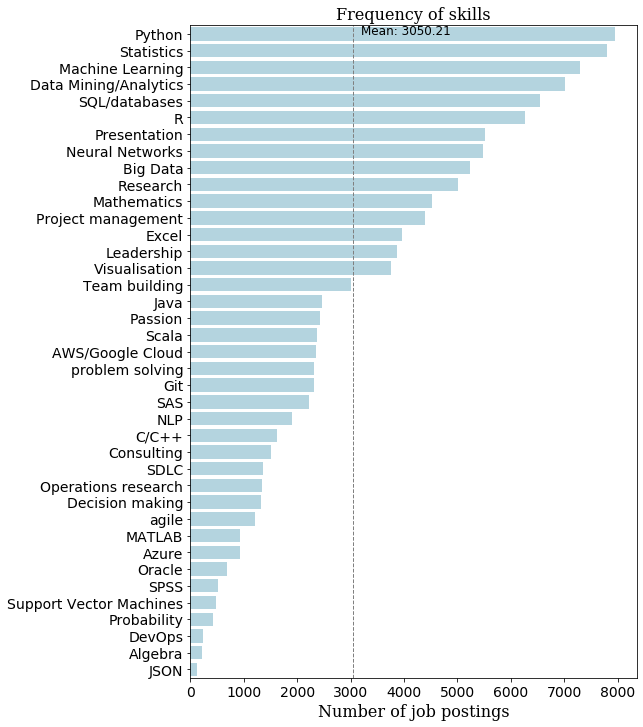

In [0]:
# plot a bar chart of all keyword categories with their frequency 
series_plot = table_all_skills.sum().sort_values(ascending=False)
title = 'Frequency of skills'
xlabel = 'Number of job postings'
plot_hbars(series_plot,title=title, with_mean=True, xlabel=xlabel, fig_height=12)

- From the bar plot above, we can see the demand of each skill in the industry as the frequency of being mentioned in the job postings. Skills with high frequency such as Python, Statistics, Machine learning, Data mining and SQL should be included in our program and course curriculum as core topics.

## 1.4 Hierachical clustering of data science keywords 
In this section, **dendrograms** visualizing the hierarchical clustering of the keywords of skills will be plotted to interpret results from the job postings.

The distance matrix is defined as 1 - the cosine similarity of each skill. Cosine similarity can be used to generate a measure of similarity between each skill. Subtracting it from 1 provides cosine distance which will be used for `plot_hc` to plot.

In [0]:
def D_matrix_cos_similarity(df):
    '''
    This function returns a distance matrix measured by 1-cosine similarity
    '''
    D = 1-cosine_similarity(df.T)
    return D

The ward clustering method is used here. It is an agglomerative clustering method and at each stage, the pair of clusters with minimum between-cluster distance are merged. The precomputed cosine distance matrix will be used to calclate a linkage matrix which then be ploted as a dendrogram.

In [0]:
def plot_hc(dmatrix,feature_name, title='Hierarchical clustering', fig_height=12, label_size=12):
    '''
    This function is to fit and plot the distance matrix of each skill 
    '''
    
    Y = ward(dmatrix)#define the linkage_matrix using ward clustering pre-computed distances
    
    fig = plt.figure(figsize=(12,fig_height))
    ax1 = fig.add_axes([0.1,0.1,0.4,0.6])
    
    Z1 = sch.dendrogram(Y, orientation='right')
    labels = feature_name[Z1['leaves']]

    ax1.set_xticks([])
    ax1.set_yticklabels(labels, fontsize=label_size)

    ax1.set_title(title)

    plt.show()
    return

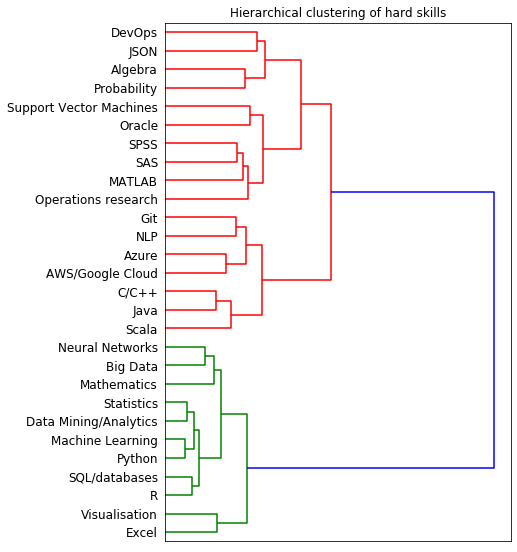

In [0]:
# Show the dendrogram of hard skills 
D_hard = D_matrix_cos_similarity(table_hard)
plot_hc(D_hard,table_hard.columns.values,title='Hierarchical clustering of hard skills')

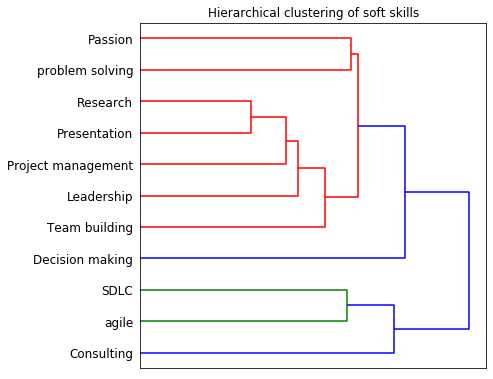

In [0]:
# Show the dendrogram of soft skills 
D_soft = D_matrix_cos_similarity(table_soft)
plot_hc(D_soft,table_soft.columns.values,fig_height=8,title='Hierarchical clustering of soft skills')

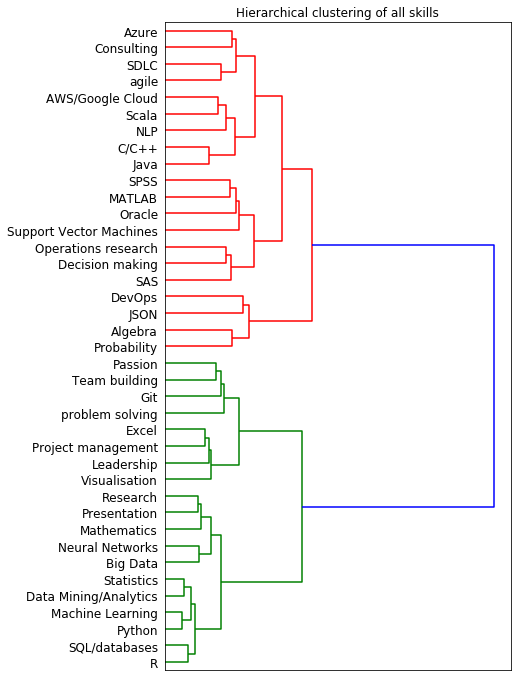

In [0]:
# Show the dendrogram of soft and hard skills 
D_all = D_matrix_cos_similarity(table_all_skills)
plot_hc(D_all,table_all_skills.columns.values,fig_height=15,title='Hierarchical clustering of all skills')

- The information obtained from above dendrograms will be used to design the topics of each course by teaching the skills in closer clusters together in the same course.

# 2. 2019 Kaggle ML & DS Survey survey analysis

## 2.1 Import kaggle survey dataset
- Source: https://www.kaggle.com/c/kaggle-survey-2019/data
- The dataset `response` contains the survey results provided by Kaggle. The survey results from 19717 participants are shown in 246 columns, representing survey questions.
- The dataset `questions` contains the list of survey questions from the 2019 Kaggle Data Science and Machine Learning Survey

In [0]:
response = pd.read_csv('Kaggle_Salary.csv',low_memory=False)
response.head()

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,...,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets
0,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,3,"30,000-39,999"
1,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
2,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,...,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,-1,14,">250,000"
3,392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
4,470,50-54,Male,-1,France,Master’s degree,Data Scientist,-1,0-49 employees,3-4,...,NaN,AWS Relational Database Service,NaN,NaN,NaN,NaN,NaN,-1,6,"60,000-69,999"


In [0]:
questions = pd.read_csv('questions_only.csv')
Q = questions.T
Q.columns=['question']
Q.head()

,question
Time from Start to Finish (seconds),Duration (in seconds)
Q1,What is your age (# years)?
Q2,What is your gender? - Selected Choice
Q3,In which country do you currently reside?
Q4,What is the highest level of formal education ...


## 2.2 Relevant questions selection

Q8: Does your current employer incorporate machine learning methods into their business?

Q13: On which platforms have you begun or completed data science courses? (Select all that apply) 

Q14: What is the primary tool that you use at work or school to analyze data?

Q19: What programming language would you recommend an aspiring data scientist to learn first?

Q18, Q20, Q24, Q25, Q28, Q29 are selected questions that their answers can be treated as skills related to data science

These questions were assumed to be the most relevant to the design of course curriculum. A dataframe will be formed with its rows representing the survey respondents and columns representing the tools, skills, or other categorical answers of the selected questions.

Bar plots will then be produced representing the frequency of answers to relevant questions.

## 2.3 Exploratory data analysis

In [0]:
def onehot_encode(question,response,end,multi=True):
    '''
    a function to Onehot encode answers of single or multiple choices questions
    '''
    if multi:
        q_start = question + '_Part_1'
        q_end = question + '_Part_' +str(end)
        Q = response.loc[:,q_start:q_end]
    else:
        Q = response.loc[:,question]
        
    Q_dummy = pd.get_dummies(Q,prefix='',dummy_na=False)
    col_names = [i.replace('_','').strip() for i in Q_dummy.columns.to_list()]
    Q_dummy.columns=col_names
    
    return Q_dummy

**Data cleaning** is automatically performed due to the use of `get_dummies`, which NaN data is ignored.

In [0]:
# Q8 ml used or not 
Q8 = onehot_encode('Q8',response,None,multi=False)

# Q13 course platform
Q13 = onehot_encode('Q13',response,'12',multi=True)

# Q14 primary tool to analyze data
Q14 = onehot_encode('Q14',response,None,multi=False)

# Q19 recommended first language to learn
Q19 = onehot_encode('Q19',response,None,multi=False)

# Q18 Q20 Q24 Q25 Q28 Q29 
Q18 = onehot_encode('Q18',response,'12',multi=True)
Q20 = onehot_encode('Q20',response,'12',multi=True)
Q24 = onehot_encode('Q24',response,'12',multi=True)
Q25 = onehot_encode('Q25',response,'8',multi=True)
Q28 = onehot_encode('Q28',response,'12',multi=True)
Q29 = onehot_encode('Q29',response,'12',multi=True)
# combine multiple choice dataset
Q_skills = pd.concat([Q18,Q20,Q24,Q25,Q28,Q29],axis=1).drop(['None','Other'],axis=1)

**The above script** used the function `onehot_encode` to create 5 dataframes containing Q8,Q13,Q14,Q19,and a subset of questions(Q18,Q20,Q24,Q25,Q28,Q29), respectively. These dataframes will be used to make bar plots of frequency of answers in the following section.

In [0]:
# Sort the data for frequency bar plots 
skills_series_to_plot = Q_skills.sum().sort_values(ascending=False)
ML_series_to_plot = Q8.sum().sort_values(ascending=False)
course_series_to_plot = Q13.sum().sort_values(ascending=False)
tool_series_to_plot = Q14.sum().sort_values(ascending=False)
language_series_to_plot = Q19.sum().sort_values(ascending=False)

The pre-defined function `plot_hbars` is used to plot horizontal bar charts

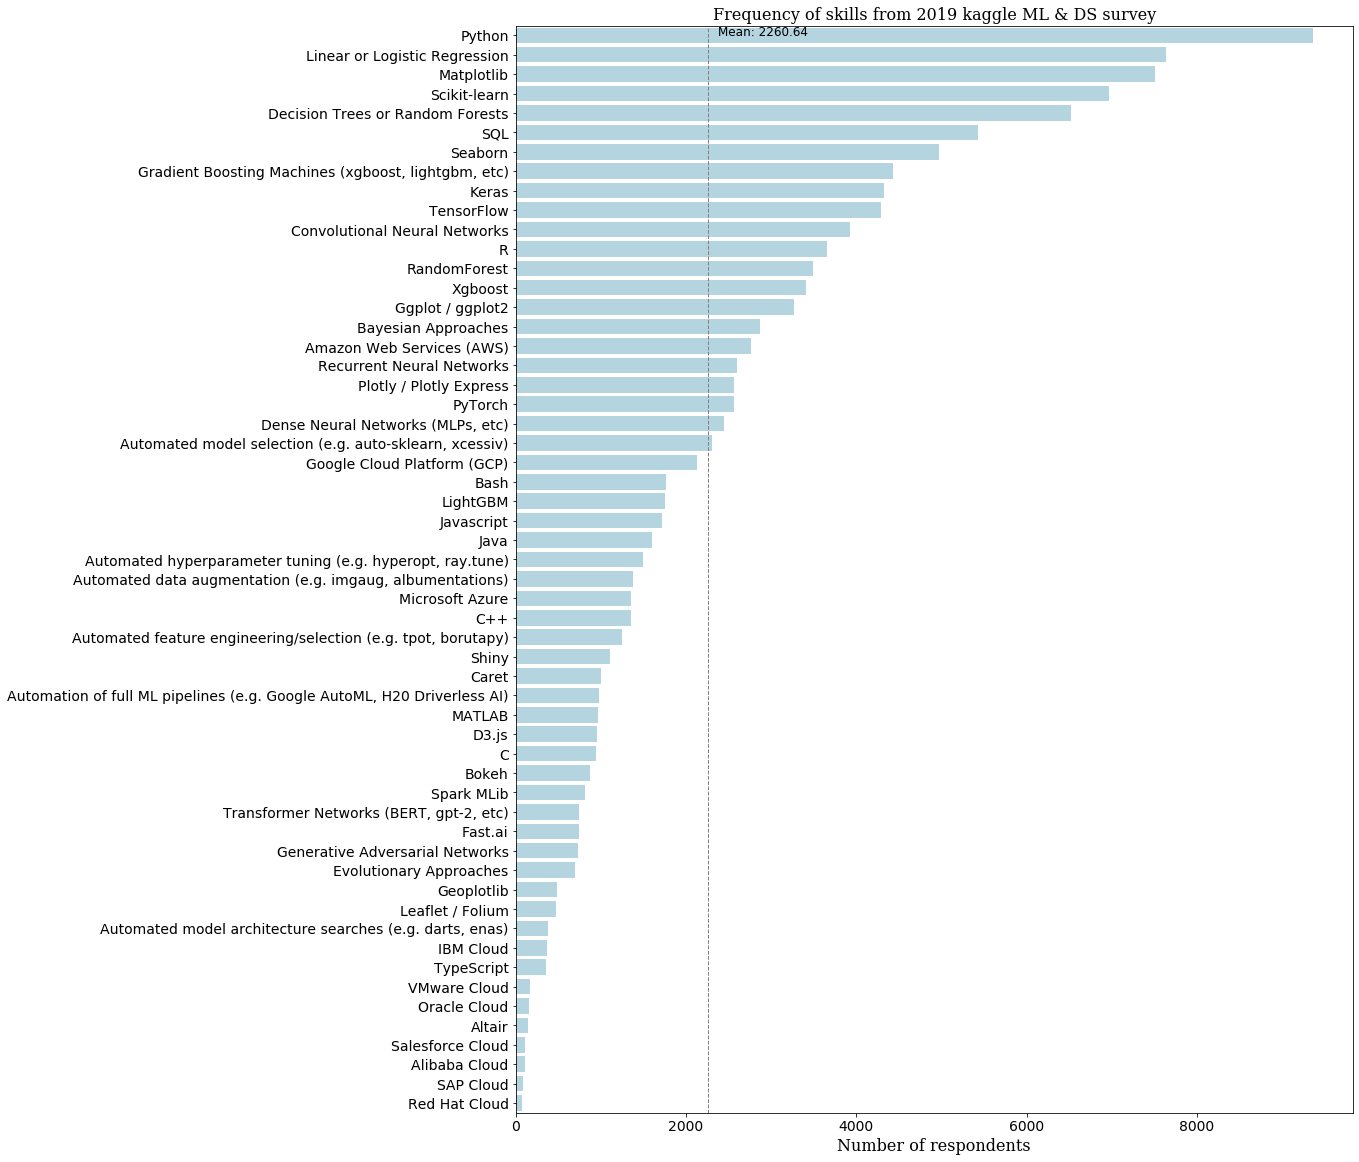

In [0]:
plot_hbars(skills_series_to_plot,title='Frequency of skills from 2019 kaggle ML & DS survey',
           xlabel='Number of respondents',fig_height=20, fig_width=15)

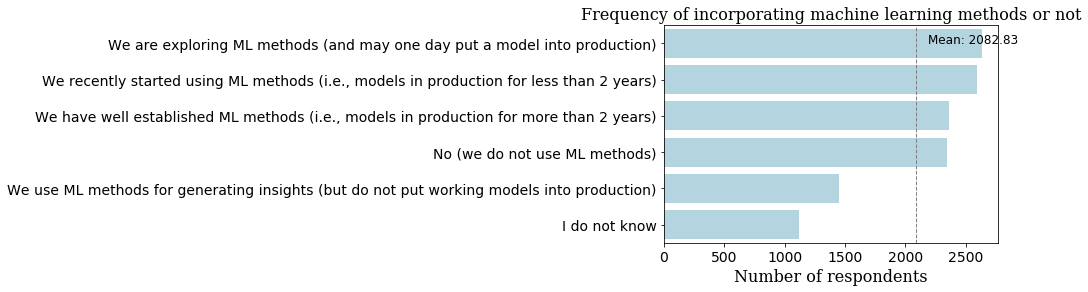

In [0]:
plot_hbars(ML_series_to_plot,title='Frequency of incorporating machine learning methods or not',
           xlabel='Number of respondents',fig_height=4, fig_width=6)

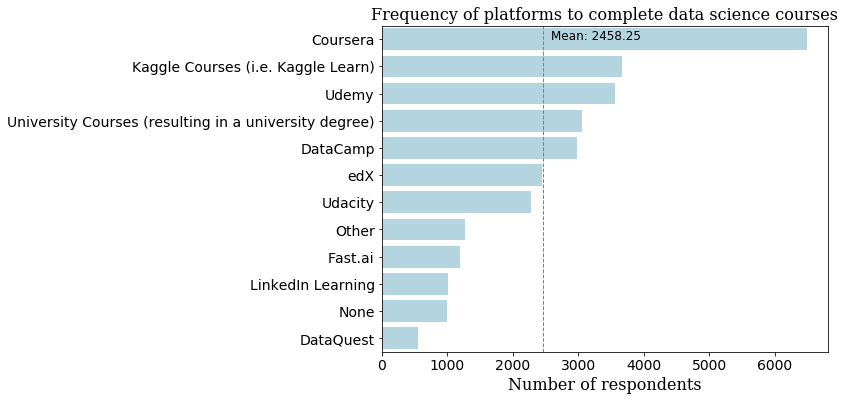

In [0]:
plot_hbars(course_series_to_plot,title='Frequency of platforms to complete data science courses',
           xlabel='Number of respondents',fig_height=6, fig_width=8)

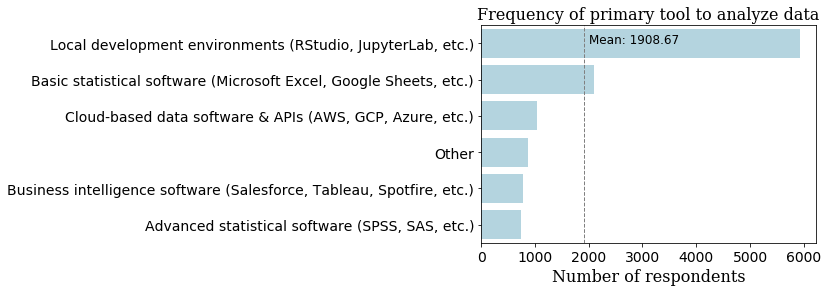

In [0]:
plot_hbars(tool_series_to_plot,title='Frequency of primary tool to analyze data',
           xlabel='Number of respondents',fig_height=4, fig_width=6)

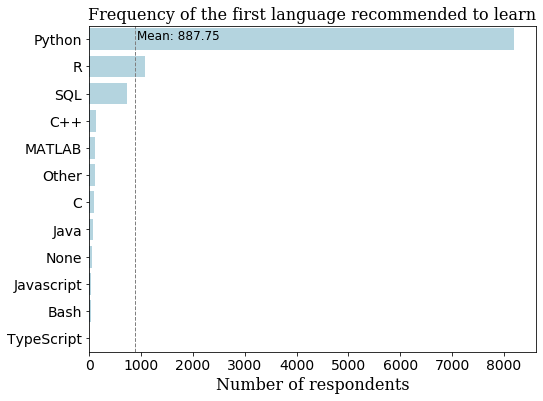

In [0]:
plot_hbars(language_series_to_plot,title='Frequency of the first language recommended to learn',
           xlabel='Number of respondents',fig_height=6, fig_width=8)

- These bar plots offer good insights into what industry professionals value when assessing proficiency of a data scientist and what importance they give to different skill sets. This information can be used to inform core desicions about the technical-oriented program design.

## 2.4 Hierachical clustering of skills from kaggle survey

A hierarchical clustering dendrogram that visualizes how each of the skills or topics relate to one another is created using the same algorithm(1 - the cosine similarity) to compute distance matrix and the ward clustering method to plot. 

In [0]:
def fit_plot_hc(dmatrix,feature_name, title='Hierarchical clustering', fig_height=12, label_size=12):
    
    #define the linkage_matrix using ward clustering pre-computed distances
    Y = ward(dmatrix)
    
    fig = plt.figure(figsize=(12,fig_height))
    ax1 = fig.add_axes([0.1,0.1,0.4,0.6])
    
    Z1 = sch.dendrogram(Y, orientation='right')
    labels = feature_name[Z1['leaves']]

    ax1.set_xticks([])
    ax1.set_yticklabels(labels, fontsize=label_size)

    ax1.set_title(title)

    plt.show()
    return

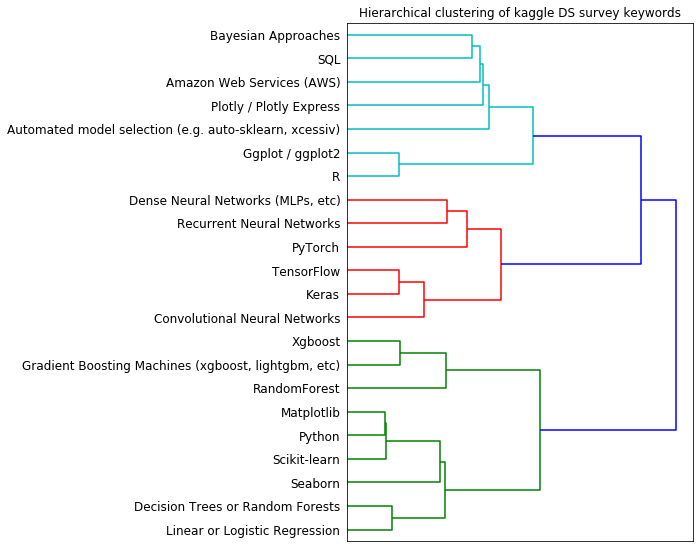

In [0]:
# select skills that are above the average frequency 
keywords = skills_series_to_plot[skills_series_to_plot>skills_series_to_plot.mean()].index.to_list()
D_dis = D_matrix_cos_similarity(Q_skills[keywords])
fit_plot_hc(D_dis,np.array(keywords), title='Hierarchical clustering of kaggle DS survey keywords', fig_height=12, label_size=12)

- The information obtained from the this dendrogram will be used to assist us in combining similar skills together to inform decisions about the design of course curriculum.

# 3. Course data analysis

In [0]:
import pandas as pd 
import string 
import re
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qg010\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
#pd.set_option('display.max.colwidth',100)
stopwords=nltk.corpus.stopwords.words('english')

## 3.1 Importing course dataset

Three datasets are collected from collected from North America top 30 university websites, Coursera online courses through web scraping and 2016 Europe data science course from Github. 

In [0]:
# Read in data
eur=pd.read_csv("data-science-courses-in-europe-2016.csv")
ns=pd.read_excel("Copy of North America Top 30 DS data.xlsx")
cs=pd.read_csv("coursera_data.csv")

# Create orginal datasets with interested columns
eur_0=eur.loc[:,['Course Title','Core modules/units/course content']]
ns_0=ns.loc[:,['Required/Core courses','Description']]
cs_0=cs.loc[:,['courses_name','courses_discription']]

# Join all dataset into one 
course_0 = pd.DataFrame(np.concatenate((eur_0.values,ns_0.values,cs_0.values), axis=0 ))
course_0.columns = [ 'Course_name', 'Course_description' ]
course_0.head()

# select pertinent column drop NaN value for north america university courses data
ns_syllabus=ns.Description
ns_syllabus=ns_syllabus.dropna()

# Remove Nan data for interested column
eur_syllabus=eur['Core modules/units/course content']
eur_syllabus=eur_syllabus[eur_syllabus!='Data not available']

# Use only the column interested 
cs_syllabus=cs.courses_discription

# Incorporate all datasets
course_desc=pd.concat([eur_syllabus,ns_syllabus,cs_syllabus],ignore_index=True,names='Description')

## 3.2 Course data cleaning

In [0]:
lemmatizer=WordNetLemmatizer()
def data_clean(txt):
    #lower text and remove punctuation
    txt=txt.lower()
    txt=''.join(word for word in txt if word not in string.punctuation.replace('+',''))
    #remove stopwords
    txt_token=re.split('\W+',txt)
    txt_ls=[word for word in txt_token if word not in stopwords]
    # remove numbers
    txt_ls=[re.sub(r'\d+','',word) for word in txt_ls]
    #lemmatization
    txt=' '.join(lemmatizer.lemmatize(word) for word in txt_ls)
    return txt

In [0]:
# Apply cleaning to dataset
course_clean=course_desc.apply(lambda x: data_clean(x))
course_clean.head()

0    data literacy digital method dat imagery digit...
1    data literacy digital method dat imagery digit...
2    data literacy digital method dat imagery digit...
3    grundlagen der wirtschaftsinformatik grundlage...
4    pflichtprogramme spezialkompetenz wirtschaftsi...
dtype: object

## 3.3 Exploration and transformation about source data 

In [0]:
# Create bag of words 
bow=''.join(text for text in course_clean).split()

# Check the most common words to better understand the data
freq=Counter(bow)
freq.most_common(10)

[('data', 1823),
 ('big', 365),
 ('analysis', 330),
 ('system', 262),
 ('learning', 261),
 ('course', 258),
 ('science', 248),
 ('business', 238),
 ('analytics', 217),
 ('machine', 193)]

In [0]:
# Vectorizing text
tfidf=TfidfVectorizer(max_features=1000)
word_vec=tfidf.fit_transform(course_clean)

# Use Kmean clustering to cluster courses to undertand better the data for other purpose 
n_clusters=10
kmeans_model = KMeans(init='k-means++', n_clusters=n_clusters, n_init=15,random_state=1,max_iter=500,verbose=0)
kmeans_model.fit(word_vec)

#returns all cluster number assigned to each word respectively
cluster_labels  = pd.Series(kmeans_model.labels_,name='KMeans label') 

In [0]:
# Created new table with KMeans labels 
labeled=pd.merge(course_clean.reset_index(),cluster_labels,left_index=True,right_index=True)
labeled.rename(columns={'index':'Original_index',0:'Description'},inplace=True)
labeled.head()

,Original_index,Description,KMeans label
0,0,data literacy digital method dat imagery digit...,2
1,1,data literacy digital method dat imagery digit...,2
2,2,data literacy digital method dat imagery digit...,2
3,3,grundlagen der wirtschaftsinformatik grundlage...,5
4,4,pflichtprogramme spezialkompetenz wirtschaftsi...,0


Six out of the ten clusters of skills were used for the determination of mandatory courses whereas the rest 4 groups and the skills that are not covered in the mandatory course were used for elective courses. One more customized cluster was added to select an appropriate project. Meanwhile, certain clusters have been adjusted according to the similarity within each cluster for improvement in accuracy. Overall, the determination of groups for mandatory and optional courses was based on the research, industrial experience and number of occurrences in the job posting dataset. 

In [0]:
# Skill clusters assoicated with required courses
course_req={
        'cluster3':('consulting|consultant|consultation|sdlc|software development lifecycle|system development lifecycle|agile|passion|team building|teamwork|team work|collaborate|git|github|version control|problem solving|critical thinking|excel|project management|project manager|management|leadership|leader|visualisation|visualization|research|presentation|communication'), # Innovation Management (soft) #Option
        'cluster6':('nlp|natural language processing|neural networks|deep learning|ann|mlp|cnn|tensorflow|keras|mnist|theano'), 
        'cluster7':('big data|spark|kafka|hive|hadoop|mapreduce|hbase|coudera|hortonworks|mathematics'), 
        'cluster8':('statistic|statistical|data mining|dm|analytic|probability'), 
        'cluster9':('algebra|machine learning|ml|python|scikit learn|matplotlib|seaborn|support vector machine|svm|machine optimization'), 
        'cluster10':('sql|database|\sr\s|aws|bayesian approaches|oracle'),  
        # Add one more customized cluster to look for project related courses 
        'cluster11':('project|capstone|internship')
} 

# Skill clusters assoicated with elective courses
course_ele={
        'cluster1':('devops|tdd|test driven|json'), 
        'cluster2':('sas|spss|matlab'), 
        'cluster4':('azure|google cloud|scala|gcp|\sc\s|\sc\+\+\s|java|jvm'), 
        'cluster5':('operation research|decision making|decision analysis')        
} 

Based on the hierarchy clustering shown before, skills were divided into 10 groups by hierarchical clustering. From each group, three to five courses from the course dataset that covered the most number of skills from the group were selected.

In [0]:
 def count_skill(text):
    '''
    Check the number of skills mentioned in the text 
    '''    
    pattern=re.compile(skill_ls)
    
    return len(set(re.findall(pattern,text)))

def element_skill(text):
    '''
    Check the specific skills mentioned in the text 
    ''' 
    pattern=re.compile(skill_ls)  
    return set(re.findall(pattern,text))

In [0]:
# The numnber for each cluster column represents how many types of skills are mentioned in this required course
for cluster_n,skill_ls in course_req.items():
    labeled[cluster_n]=labeled['Description'].apply(count_skill)
    labeled['Spec_skills_'+cluster_n]=labeled['Description'].apply(element_skill)
labeled.head()

,Original_index,Description,KMeans label,cluster3,Spec_skills_cluster3,cluster6,Spec_skills_cluster6,cluster7,Spec_skills_cluster7,cluster8,Spec_skills_cluster8,cluster9,Spec_skills_cluster9,cluster10,Spec_skills_cluster10,cluster11,Spec_skills_cluster11
0,0,data literacy digital method dat imagery digit...,2,3,"{management, research, git}",0,{},0,{},0,{},0,{},0,{},1,{project}
1,1,data literacy digital method dat imagery digit...,2,2,"{management, git}",0,{},0,{},0,{},0,{},0,{},1,{project}
2,2,data literacy digital method dat imagery digit...,2,1,{git},0,{},0,{},0,{},0,{},0,{},0,{}
3,3,grundlagen der wirtschaftsinformatik grundlage...,5,0,{},0,{},0,{},0,{},0,{},0,{},0,{}
4,4,pflichtprogramme spezialkompetenz wirtschaftsi...,0,1,{management},0,{},0,{},0,{},0,{},0,{},0,{}


## 3.4 Visualization of course selection 

In [0]:
def check_course(cluster_name,number_rows_checked):
    '''
    Check the first few sorted rows of orginal text given specific column name
    '''
    sorted_table=labeled.sort_values(by=[cluster_name],ascending=False).head(number_rows_checked)
    original=course_desc[sorted_table.Original_index]
    final_table=pd.concat([sorted_table[cluster_name].reset_index(drop=True),original.reset_index(drop=True)],axis=1)
    final_table.rename(columns={0:'Description'},inplace=True)
    course_name=final_table['Description'].apply(lambda x:course_0[course_0['Course_description']==x].Course_name.values[0]).rename('Title')
    spec_skill=sorted_table['Spec_skills_'+cluster_name]
    final_table_update=pd.concat([final_table.reset_index(drop=True),course_name.reset_index(drop=True),spec_skill.reset_index(drop=True)],axis=1)
    
    return final_table_update
 

In [0]:
# Check required courses
check_course('cluster9',10)

,cluster9,Description,Title,Spec_skills_cluster9
0,4,Topics: statisti...,CS 229. Machine ...,"{ml, python, alg..."
1,4,Doing Machine Le...,Get Started in M...,"{ml, machine lea..."
2,3,A short course p...,CME 250A: Machin...,{machine learnin...
3,3,Setting Up a Dev...,HDP Data Science,"{ml, machine lea..."
4,3,Foundations Of P...,Data Science,{machine learnin...
5,3,Basic Tutorials ...,Lisbon Machine L...,{machine learnin...
6,3,The objective of...,OIT 367. Busines...,{machine learnin...
7,2,The course will ...,DSC 478 Program...,{machine learnin...
8,2,"Data mining, mac...",Basic Data Analy...,{machine learnin...
9,2,Analysing big da...,1-Day Course Spa...,"{ml, machine lea..."


In [0]:
# Check all clusters for required courses
pd.set_option('display.max.colwidth',20)
for cluster_n,skill_ls in course_req.items():
    print(check_course(cluster_n,4))

   cluster3          Description                Title Spec_skills_cluster3
0         5  Probability and ...  Computing: Data ...  {problem solving...
1         5  Module 1: Introd...  Leadership Chall...  {presentation, m...
2         5  Business: Introd...  Big Data Analyti...  {research, proje...
3         4  Organizational B...  ORGB 661 - Ethic...  {leadership, man...
   cluster6          Description                Title Spec_skills_cluster6
0         2  Introduction to ...  Data Science Tra...  {nlp, natural la...
1         2  Bases: Recurrent...  Deep Learning fo...    {tensorflow, nlp}
2         2  Course focuses o...   CSC 578 Neural ...  {ann, deep learn...
3         2  This course, tau...  DSCC 481: Artifi...  {cnn, deep learn...
   cluster7          Description                Title Spec_skills_cluster7
0         7  Hadoop Architect...  Big Data Trainin...  {hadoop, hbase, ...
1         6  Hadoop Architect...  Hadoop Training ...  {hadoop, hbase, ...
2         5  Master the c

In [0]:
# The numnber for each cluster column represents how many types of skills are mentioned in this elected course
for cluster_n,skill_ls in course_ele.items():
    labeled[cluster_n]=labeled['Description'].apply(count_skill)
    # Create a column to indicate specific skills mentioned 
    labeled['Spec_skills_'+cluster_n]=labeled['Description'].apply(element_skill)
labeled.head()

,Original_index,Description,KMeans label,cluster3,Spec_skills_cluster3,cluster6,Spec_skills_cluster6,cluster7,Spec_skills_cluster7,cluster8,...,cluster11,Spec_skills_cluster11,cluster1,Spec_skills_cluster1,cluster2,Spec_skills_cluster2,cluster4,Spec_skills_cluster4,cluster5,Spec_skills_cluster5
0,0,data literacy di...,2,3,"{management, res...",0,{},0,{},0,...,1,{project},0,{},0,{},0,{},0,{}
1,1,data literacy di...,2,2,"{management, git}",0,{},0,{},0,...,1,{project},0,{},0,{},0,{},0,{}
2,2,data literacy di...,2,1,{git},0,{},0,{},0,...,0,{},0,{},0,{},0,{},0,{}
3,3,grundlagen der w...,5,0,{},0,{},0,{},0,...,0,{},0,{},0,{},0,{},0,{}
4,4,pflichtprogramme...,0,1,{management},0,{},0,{},0,...,0,{},0,{},0,{},0,{},0,{}


In [0]:
# Check all clusters for elective courses
for cluster_n,skill_ls in course_ele.items():
    print(check_course(cluster_n,4))

   cluster1          Description                Title Spec_skills_cluster1
0         1  How to use and q...  Databases and Da...               {json}
1         1  Introduction Mon...       Apache MongoDB               {json}
2         1  This course will...  Using Python to ...               {json}
3         1  Introduction to ...       Apache CouchDB               {json}
   cluster2          Description                Title Spec_skills_cluster2
0         2  Foundations Of P...         Data Science       {spss, matlab}
1         1  Available Course...  Data Management ...                {sas}
2         1  Mathematical and...  Statistics and A...             {matlab}
3         1  1. Tools for Ana...   Business Analytics               {spss}
   cluster4          Description                Title Spec_skills_cluster4
0         3  Basic knowledge ...      Data Structures   {java,  c , scala}
1         2  What is Rcpp and...  Masterclass: Spe...         { c , scala}
2         2  Combinatoric

In [0]:
# Check top elective courses with specific cluster for better visualization 
check_course('cluster4',10)

,cluster4,Description,Title,Spec_skills_cluster4
0,3,Basic knowledge ...,Data Structures,"{java, c , scala}"
1,2,What is Rcpp and...,Masterclass: Spe...,"{ c , scala}"
2,2,Combinatorics An...,Data Science,"{java, c }"
3,2,In-depth coverag...,\nCS 316. Advanc...,"{ c , scala}"
4,1,Select appropria...,1-Day Course Pro...,{scala}
5,1,This course teac...,Object-Oriented ...,{ c }
6,1,Introduction to ...,DEV 3200 - HBase...,{java}
7,1,Simulation Model...,Data and Computa...,{ c }
8,1,Introduction to ...,Building Apache ...,{java}
9,1,Data analysis ha...,Data Manipulatio...,{scala}
